# Simulating the effect of pixelization errors on Gaussian fittings

## Importing packages

In [2]:
import os
import sys
sys.path.append('./')

import math
import numpy as np
from numpy import size
from scipy.optimize import curve_fit
from astropy.table import Table, Column
from astropy.io import fits
from spectral_cube import SpectralCube
#import astropy.units as u


import matplotlib
#matplotlib.use('PDF')
import matplotlib.pyplot as plt
%matplotlib inline

## Defining functions and classes

In [3]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [4]:
# parent class
class spectrum:
    'Parent class for a spectrum \n \
     Attributes \n \
     num_components ( int ) : counters for total number of spectra \n \
    '
    num_components = 0
    
    def __init__(self):
        spectrum.num_components += 1
    
    def __del__(self):
        spectrum.num_components -= 1
    

    
# subclasses
class gaussian_spectrum( spectrum ):
    'Sub-class of spectrum. Gaussian profile \n \
     constructed by, e.g., spectrum1 = gaussian_spectrum() \n\n \
     Attributes: \n \
     A (float) : Amplitude of the gaussian spectrum \n \
     sigma (float) : standard deviation [bins] of the gaussian spectrum \n \
     bins (int) : number of bins to sample the spectrum. \n \
     data (numpy array) : the stored intensity values \n \
     resampleddata (numpy array) : the stored, resampled intensity values \n \
     '

    num_components = 0

    def __init__(self, name = 'gaussian_unknown', 
               A=1.0, sigma=1.0, bins=256):
        spectrum.num_components += 1
        gaussian_spectrum.num_components += 1
        self.name  = name
        self.A = A
        self.sigma = sigma
        self.bins  = bins
        self.x     = np.arange(0, bins)
        self.center = float(bins - 1) / 2.0

        self.data = \
        A * np.exp( - ( self.x - self.center)**2.0 / (2.0 * sigma**2) )
        self.resampleddata = self.data
    # print( self.name )
    # print( self.data )
    
    def __del__(self):
        spectrum.num_components -= 1
        gaussian_spectrum.num_components -= 1

    def resample(self, pixelsize=20, pixelshift=10):
    # pixelsize: pixelsize in units of bin
    # pixelshift: In unit of bin. A parameter to shift the resampling pixels with respect to the
    #             original Gaussian spectrum
    
        for i in range(0, pixelshift):
            self.resampleddata[i] = np.sum( self.data[0:pixelshift] ) / pixelsize

        resampled_bins = int( 
            ( self.bins - pixelshift ) / pixelsize
        )
        for i in range(0, resampled_bins):
            for j  in range(0, pixelsize):
                k = pixelshift + pixelsize * i + j
                start = pixelshift + pixelsize * i
                end   = pixelshift + pixelsize * (i+1)
                self.resampleddata[k] = np.sum( self.data[start:end] ) / pixelsize
        
    def add_noise(self, RMS=0.1):
    # RMS: the RMS noise level
        noise = np.random.normal(0.0, RMS, self.bins)
        self.data = self.data + noise
    
    def refit_gaussian(self):
        p0 = [1., self.bins/2.0, 1.]
        coeff, var_matrix = curve_fit(gauss, self.x, self.resampleddata, p0=p0)
        return coeff




def resampleobs(sp, bins):
    # pixelsize: pixelsize in units of bin
    # pixelshift: In unit of bin. A parameter to shift the resampling pixels with respect to the
    #             original Gaussian spectrum

    #spdata = np.array( range( bins ) )
    #print spdata
    numbins = int( bins *1.0 / len(sp) )
    spdata = []
    j = 0
    i = 0
    for j in range( len(sp) ):
        for k in range(0, numbins):
            if i < bins:
                #print 'sp[j]={}'.format( sp[j] )
                spdata = np.append( spdata, sp[j] )
                #print 'i={}, k={}, j={}'.format( i, k, j )
                #print 'spdata[i] = {}'.format( spdata[i] )
                i += 1
    #print len(spdata)
    max_index = int( (np.max( ( np.where( spdata == np.nanmax(spdata) )[0] ) ) - \
                        len(np.where( spdata == np.nanmax(spdata) )[0])/2.0))
    
    delta_index = max_index - bins/2
    #print delta_index, max_index
    fvpix   = (8.229/600) * delta_index - 8  # the velocity of first pixel in km/s
    #print fvpix
    spdata1 = []
    j = delta_index - 1
    for i in range( (len(spdata) - delta_index) ):
        spdata1 = np.append( spdata1, spdata[j] )
        #print 'spdata[j] = {}'.format(spdata[j])
        j += 1
        #print j , i
    return spdata1, fvpix

print "Done ~ ^_^ ~"

Done ~ ^_^ ~


## Printing help files

In [36]:
print ( 'spectrum :\n', spectrum.__doc__ )
print ( 'gaussian_spectrum :\n', gaussian_spectrum.__doc__ )

spectrum :
 Parent class for a spectrum 
      Attributes 
      num_components ( int ) : counters for total number of spectra 
   
gaussian_spectrum :
 Sub-class of spectrum. Gaussian profile 
      constructed by, e.g., spectrum1 = gaussian_spectrum() 

    Attributes: 
    A (float) : Amplitude of the gaussian spectrum 
    sigma (float) : standard deviation [bins] of the gaussian spectrum 
    bins (int) : number of bins to sample the spectrum. 
    data (numpy array) : the stored intensity values 
    resampleddata (numpy array) : the stored, resampled intensity values 
   


## Plotting results

In [5]:
Target = 'imfit_finial_results_addradec_sortflux_table_pbflux_mass_Mach_seperatemass_area_extP.fits'
T = Table.read(Target, hdu=3)
Mgas = T['Mass']          # gas mass
Dreff = T['decr_eff']     # beam-deconvolved effective radius in arcsec
Asig = T['fitted_Asigma']   # (H13CO+) non-thermal + sound speed
T[43]
#T.show_in_browser()


f1 = 'fitted_h13copfits_results_snr5_Apr9_refit_somepixels_flaged.fits'
f2 = 'imfit_densecore_id.fits'
f3 = 'IRDC_G350_H13COP_JUNE27_cubemask_niters1e4_thresh12_multi072142.image.fits'
f4 = 'map_compidex.fits'

hdu1 = fits.open(f1)
hdu2 = fits.open(f2)
hdu3 = fits.open(f3)
hdu4 = fits.open(f4)

data1 = hdu1[0].data
data2 = hdu2[0].data[0]
data3 = hdu3[0].data
hdr3  = hdu3[0].header
data4 = hdu4[0].data

print data1.shape, data2.shape



G       = 4.301e-3  # pc * Msolar^-1 * (km/s)^2
v_delta = 0.21      # km/s
v_pix   = v_delta / 16.0  # general finner pixel grids for the original spectrum

# Assuming cores are virialized
alpha      = 2.0
sigma2fwhm = 2.*np.sqrt(2*np.log(2))
Reff       = Dreff * (1300.0 / 206265.0)         # angular radius --> 
sigma      = np.sqrt(alpha * Mgas * G /(5.* Reff))  # km/s

peak_intensity = []
peak_sn        = []
spcube         = []
for i in range(size(T)):
    Adata1         = np.where(data2 == i, data1[0], np.nan)
    Adata1_err     = np.where(data2 == i, data1[3], np.nan)
    peak_intensity = np.append(peak_intensity, np.nanmean(Adata1))
    peak_sn        = np.append(peak_sn, np.nanmean(Adata1)*1.0/np.nanmean(Adata1_err))
    #print np.nanmean(Adata1)*1.0/np.nanmean(Adata1_err)
    #print i
    cube    = np.where( data2 == i, data3, np.nan )
    HDU     = fits.PrimaryHDU( data=cube, header=hdr3 )
    HDUList = fits.HDUList( [HDU] )
    cube    = SpectralCube.read( HDUList )
    sp      = cube.mean( axis=(1,2) )
    spcube.append( sp.value )
## 29, 47  without sigma information
# 32, 33, 40, 41, 45, 46, 48, without beam-deconvolved radius

core_index = []
for i in range(size(T)):
    mapidex = np.where(data2 == i, data4, np.nan)
    if np.nanmax(mapidex) > 1:
        core_index.append(i)

print "Done ~ ^ ^ ~"

(24, 1536, 1024) (1536, 1024)


/Applications/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in divide
/Applications/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/Applications/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: Mean of empty slice
/Applications/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: All-NaN slice encountered


Done ~ ^ ^ ~


---

### Assuming the cores are virialized 

#### Plotting the spectral for all of dense cores that have H13CO+ detection.
---

In [ ]:

kk = range(0, size(Mgas) )


jj = [29,32,33,40,41,45,46,47,48]
for i in jj:
    temp = kk.index(i)
    kk.pop(temp)
#print kk

#print kk

iterations = 1000
linewidth_fits = np.zeros(iterations)


for i in kk:
#for i in range( 0, 5 ):
  # Initialize figures
    fig = plt.figure(figsize=(9, 9))
    figure = plt.subplot(1, 1, 1)
    figure.tick_params(axis='both', which='major', labelsize=18)


    for itr in range(0, iterations):
        
    # generate spectrum
        test_spectrum = gaussian_spectrum(
                                    name = 'test', 
                                    #A = peak_intensity[i],
                                    A = np.nanmax(spcube[i]),
                                    sigma = sigma[i]/v_pix, 
                                    bins = 600)

    # plotting the original gaussian spectrum
        if (itr == (iterations-1) ):
            plt.plot(test_spectrum.x , test_spectrum.data, \
                     '-.',
                     color = (0, 0, 0.0, 0.8),
                     linewidth=4, 
                     label = 'Original spectrum'
                    ) 
            
    # plotting the observed spctrum
            sp_data, fvpix = resampleobs( spcube[i], 600 )
            plt.plot(sp_data, \
                     '-.',
                     color = 'lime',
                     linewidth=4, 
                     label = 'Observed spectrum'
                    ) 

    
        # inject noise
        noise = peak_intensity[i] / peak_sn[i]
        noise = noise * np.sqrt( v_delta / v_pix )
        test_spectrum.add_noise( RMS = noise )
        # plt.plot(
        #        test_spectrum.x , test_spectrum.data,
        #        color = (0, 0.8, 0.0, 0.3),
        #        linewidth=2, label = 'Noisy spectrum'
        #        )
           
        # resampling
        test_spectrum.resample(pixelsize = int(v_delta / v_pix), pixelshift=0)
        if (itr == (iterations-1) ):
            plt.plot(test_spectrum.x , test_spectrum.resampleddata,
               color = (0.8, 0.0, 0.0, 0.8),
               linewidth = 2, 
               label = 'Resampled spectrum'
               )    
        else:
            pass  

        # fit Gaussian and print the results
        coeff = test_spectrum.refit_gaussian()
        spectrum_fit = gauss( test_spectrum.x, *coeff)
        if (itr == (iterations-1) ):    
            plt.plot(test_spectrum.x, spectrum_fit, 
               color = (1, 0.5, 0, 0.5),
               label='Fitted Gaussian'
               )
        else:
            if ( itr % 5 == 0):
                plt.plot(test_spectrum.x, spectrum_fit, 
                color = (1, 0.5, 0, 0.5),
                 )
        linewidth_fits[itr] = coeff[2] * v_delta * (v_pix/v_delta)

        if (itr == 0):
            plt.text( 0.6, 0.95,
               'Original $\sigma=$%s kms$^{-1}$' %(str( round( sigma[i],2 ) )), 
               {'color': 'C0', 'fontsize': 16},
               transform=figure.transAxes
              )
    
        if (itr == (iterations-1) ):
            plt.text( 0.55, 0.9,
                     'Fitted $\sigma=$%s$\pm$%s kms$^{-1}$' 
                    %( str( round( np.mean(linewidth_fits), 2 ) ), str( round( np.std(linewidth_fits), 2 ) )), 
                    {'color': 'C0', 'fontsize': 16},
                    transform=figure.transAxes
                    )

            plt.text( 0.6, 0.85,
                     'Observed $\sigma=$%s kms$^{-1}$' %(str( round( Asig[i], 2 ) )), 
                     {'color': 'C0', 'fontsize': 16},
                     transform=figure.transAxes
                    )
                     
    plt.title('M$_{gas}$=%s M$_{\odot}$ Radius=%s pc' 
             %( str( round( Mgas[i],2 ) ), str( round( Reff[i],2 ) )  ), 
             size=18
           )
    plt.xlabel( 'v$_{lsr}$ (km s$^{-1}$)', size=18)
    plt.ylabel( 'Flux (Jy beam$^{-1}$)', size=18)
    plt.xticks((0,100, 200, 300, 400, 500, 600), 
               ('%s'%( str( round(fvpix, 2))),
                '%s'%( str( round(fvpix+100*8.229/600, 2))),
                '%s'%( str( round(fvpix+200*8.229/600, 2))),
                '%s'%( str( round(fvpix+300*8.229/600, 2))),
                '%s'%( str( round(fvpix+400*8.229/600, 2))),
                '%s'%( str( round(fvpix+500*8.229/600, 2))),
                '%s'%( str( round(fvpix+600*8.229/600, 2))),
               ), size=15)
    plt.legend(loc=2, fontsize=14)



---

### Assuming the cores are virialized 

#### Plotting the spectral for the dense cores that only detected single velocity component in H13CO+

---

21 321
-7.711985


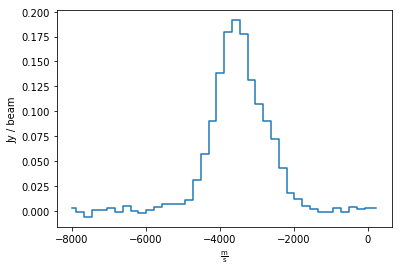

In [31]:

def resampleobs(sp, bins):
    # pixelsize: pixelsize in units of bin
    # pixelshift: In unit of bin. A parameter to shift the resampling pixels with respect to the
    #             original Gaussian spectrum

    #spdata = np.array( range( bins ) )
    #print spdata
    numbins = int( bins *1.0 / len(sp) )
    spdata = []
    j = 0
    i = 0
    for j in range( len(sp) ):
        for k in range(0, numbins):
            if i < bins:
                #print 'sp[j]={}'.format( sp[j] )
                spdata = np.append( spdata, sp[j] )
                #print 'i={}, k={}, j={}'.format( i, k, j )
                #print 'spdata[i] = {}'.format( spdata[i] )
                i += 1
    #print len(spdata)
    max_index = int( (np.max( ( np.where( spdata == np.nanmax(spdata) )[0] ) ) - \
                        len(np.where( spdata == np.nanmax(spdata) )[0])/2.0))
    
    delta_index = max_index - bins/2
    #print delta_index, max_index
    fvpix   = (8.229/600) * delta_index - 8  # the velocity of first pixel in km/s
    #print fvpix
    spdata1 = []
    j = delta_index - 1
    for i in range( (len(spdata) - delta_index) ):
        spdata1 = np.append( spdata1, spdata[j] )
        #print 'spdata[j] = {}'.format(spdata[j])
        j += 1
        #print j , i
    return spdata1, fvpix
    #print "Done ~ ^^ ~"
    
sp_data, fvpix = resampleobs( spcube[1], 600 )
#print len(sp_data), len(spcube[1])

cube    = np.where( data2 == 1, data3, np.nan )
HDU     = fits.PrimaryHDU( data=cube, header=hdr3 )
HDUList = fits.HDUList( [HDU] )
cube    = SpectralCube.read( HDUList )
sp      = cube.mean( axis=(1,2) )
sp.quicklook()
#print 8.229/600

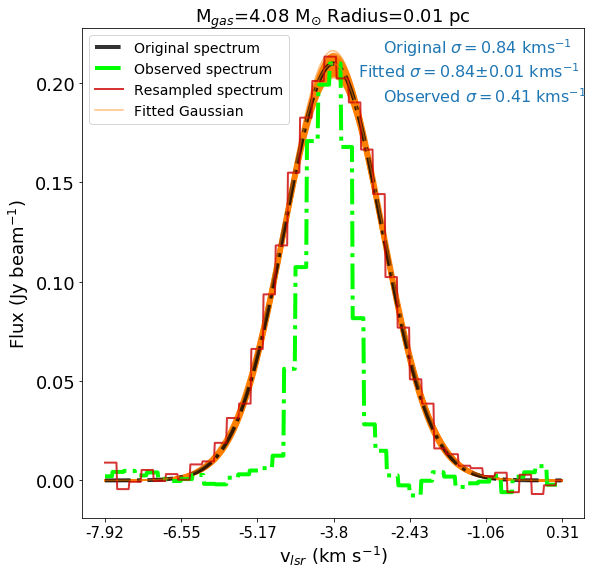

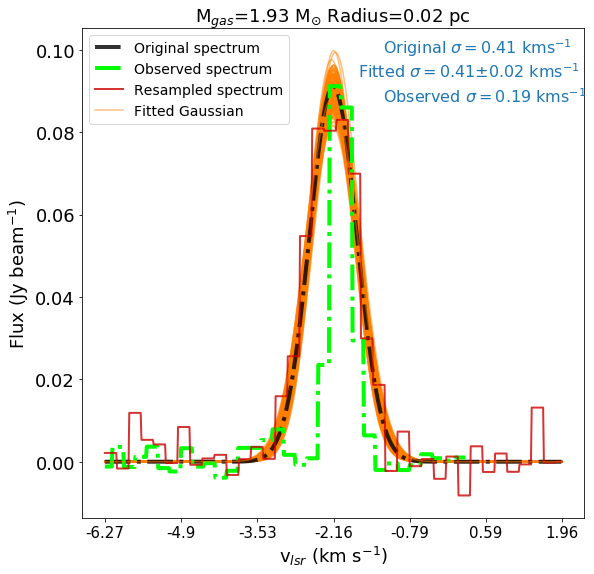

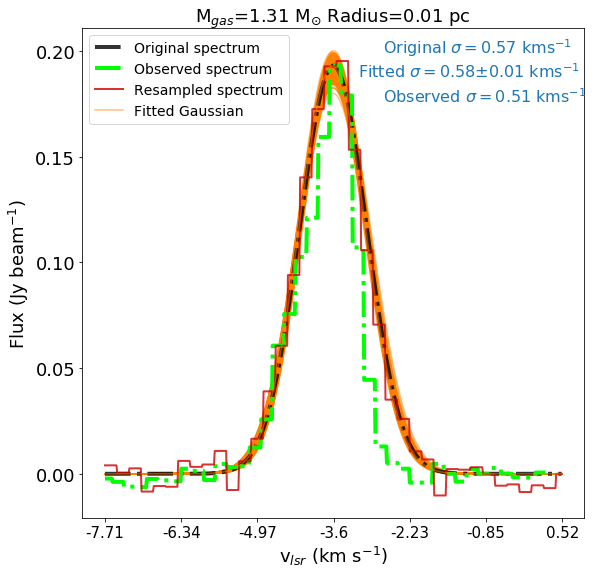

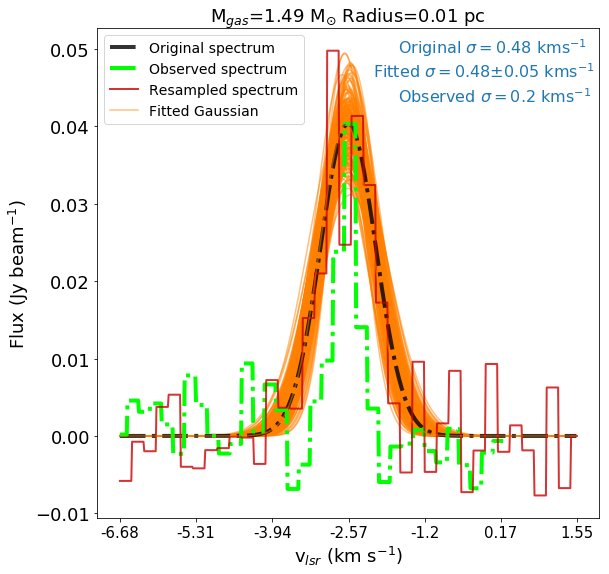

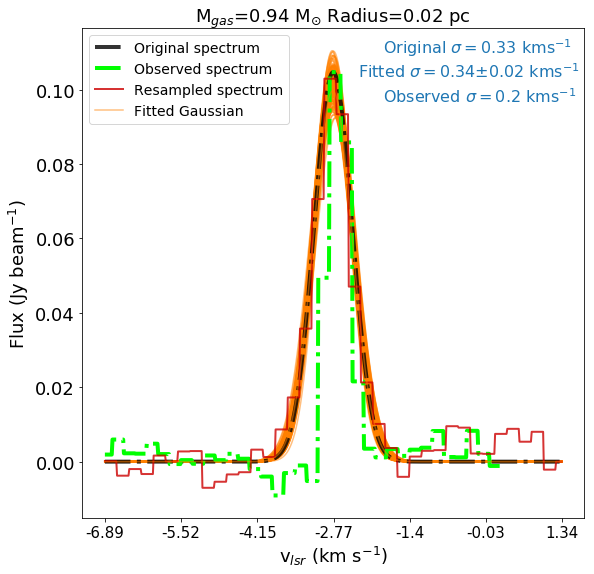

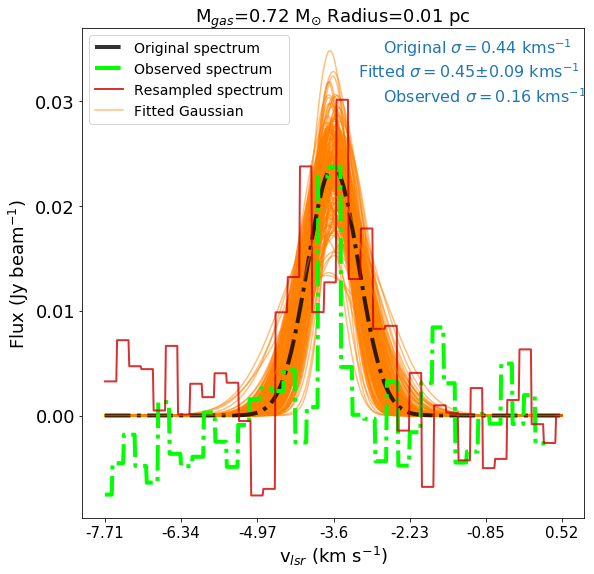

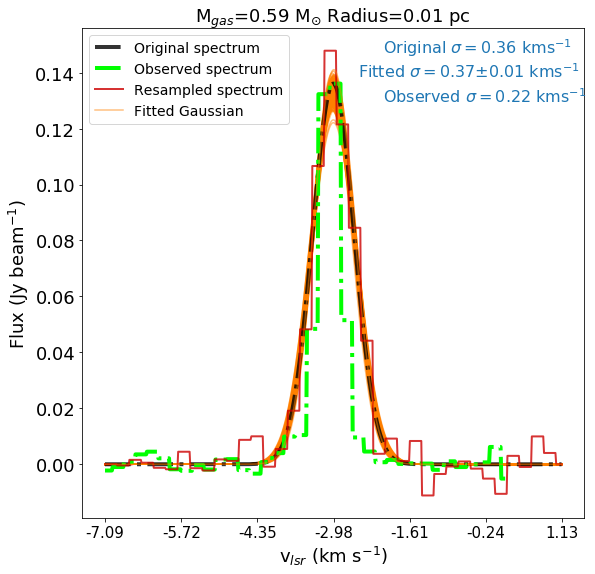

In [34]:
kk = range(0, size(Mgas) )

for i in core_index:
    temp = kk.index(i)
    #print temp
    kk.pop(temp)

#print kk

jj = [29,33,40,45,46,47,48]
for i in jj:
    temp = kk.index(i)
    kk.pop(temp)
#print kk



iterations = 1000
linewidth_fits = np.zeros(iterations)


for i in kk:
#for i in range( 0, 5 ):
  # Initialize figures
    fig = plt.figure(figsize=(9, 9))
    figure = plt.subplot(1, 1, 1)
    figure.tick_params(axis='both', which='major', labelsize=18)


    for itr in range(0, iterations):
        
    # generate spectrum
        test_spectrum = gaussian_spectrum(
                                    name = 'test', 
                                    #A = peak_intensity[i], 
                                    A = np.nanmax(spcube[i]),
                                    sigma = sigma[i]/v_pix, 
                                    bins = 600)

    # plotting the original gaussian spectrum
        if (itr == (iterations-1) ):
            plt.plot(test_spectrum.x , test_spectrum.data, \
                     '-.',
                     color = (0, 0, 0.0, 0.8),
                     linewidth=4, 
                     label = 'Original spectrum'
                    ) 
            
    # plotting the observed spctrum
            sp_data, fvpix = resampleobs( spcube[i], 600 )
            plt.plot(sp_data, \
                     '-.',
                     color = 'lime',
                     linewidth=4, 
                     label = 'Observed spectrum'
                    ) 

    
        # inject noise
        noise = peak_intensity[i] / peak_sn[i]
        noise = noise * np.sqrt( v_delta / v_pix )
        test_spectrum.add_noise( RMS = noise )
        # plt.plot(
        #        test_spectrum.x , test_spectrum.data,
        #        color = (0, 0.8, 0.0, 0.3),
        #        linewidth=2, label = 'Noisy spectrum'
        #        )
           
        # resampling
        test_spectrum.resample(pixelsize = int(v_delta / v_pix), pixelshift=0)
        if (itr == (iterations-1) ):
            plt.plot(test_spectrum.x , test_spectrum.resampleddata,
               color = (0.8, 0.0, 0.0, 0.8),
               linewidth = 2, 
               label = 'Resampled spectrum'
               )    
        else:
            pass  

        # fit Gaussian and print the results
        coeff = test_spectrum.refit_gaussian()
        spectrum_fit = gauss( test_spectrum.x, *coeff)
        if (itr == (iterations-1) ):    
            plt.plot(test_spectrum.x, spectrum_fit, 
               color = (1, 0.5, 0, 0.5),
               label='Fitted Gaussian'
               )
        else:
            if ( itr % 5 == 0):
                plt.plot(test_spectrum.x, spectrum_fit, 
                color = (1, 0.5, 0, 0.5),
                 )
        linewidth_fits[itr] = coeff[2] * v_delta * (v_pix/v_delta)

        if (itr == 0):
            plt.text( 0.6, 0.95,
               'Original $\sigma=$%s kms$^{-1}$' %(str( round( sigma[i],2 ) )), 
               {'color': 'C0', 'fontsize': 16},
               transform=figure.transAxes
              )
    
        if (itr == (iterations-1) ):
            plt.text( 0.55, 0.9,
                     'Fitted $\sigma=$%s$\pm$%s kms$^{-1}$' 
                    %( str( round( np.mean(linewidth_fits), 2 ) ), str( round( np.std(linewidth_fits), 2 ) )), 
                    {'color': 'C0', 'fontsize': 16},
                    transform=figure.transAxes
                    )

            plt.text( 0.6, 0.85,
                     'Observed $\sigma=$%s kms$^{-1}$' %(str( round( Asig[i], 2 ) )), 
                     {'color': 'C0', 'fontsize': 16},
                     transform=figure.transAxes
                     )
            
    plt.title('M$_{gas}$=%s M$_{\odot}$ Radius=%s pc' 
             %( str( round( Mgas[i],2 ) ), str( round( Reff[i],2 ) )  ), 
             size=18
           )
    plt.xlabel( 'v$_{lsr}$ (km s$^{-1}$)', size=18)
    plt.ylabel( 'Flux (Jy beam$^{-1}$)', size=18)
    plt.xticks((0,100, 200, 300, 400, 500, 600), 
               ('%s'%( str( round(fvpix, 2))),
                '%s'%( str( round(fvpix+100*8.229/600, 2))),
                '%s'%( str( round(fvpix+200*8.229/600, 2))),
                '%s'%( str( round(fvpix+300*8.229/600, 2))),
                '%s'%( str( round(fvpix+400*8.229/600, 2))),
                '%s'%( str( round(fvpix+500*8.229/600, 2))),
                '%s'%( str( round(fvpix+600*8.229/600, 2))),
               ),size=15)
    plt.legend(loc=2, fontsize=14)




In [13]:
print 0.21/16


0.013125


---

### Generating the spectrum based on the observed paramters of H13CO+

#### The original A and sigma are from the measurement of H13CO+

---

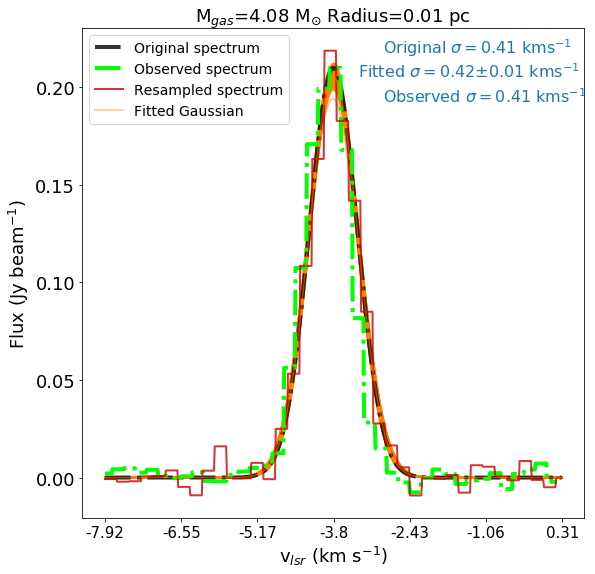

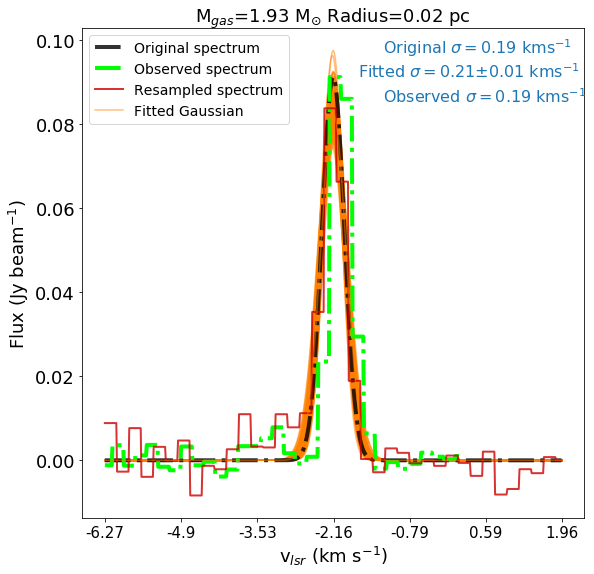

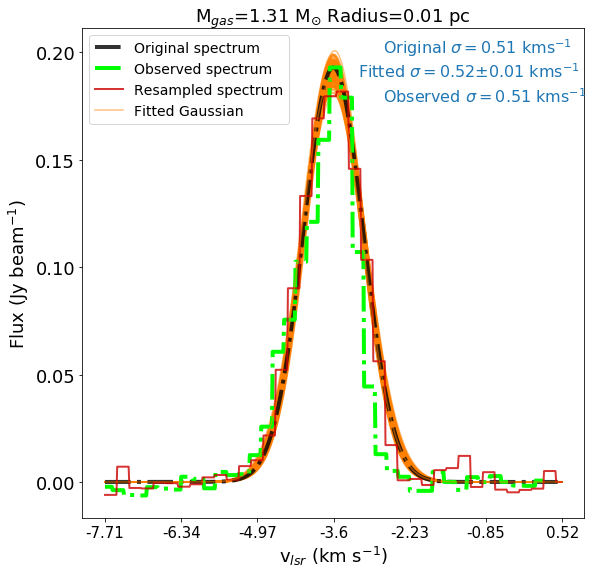

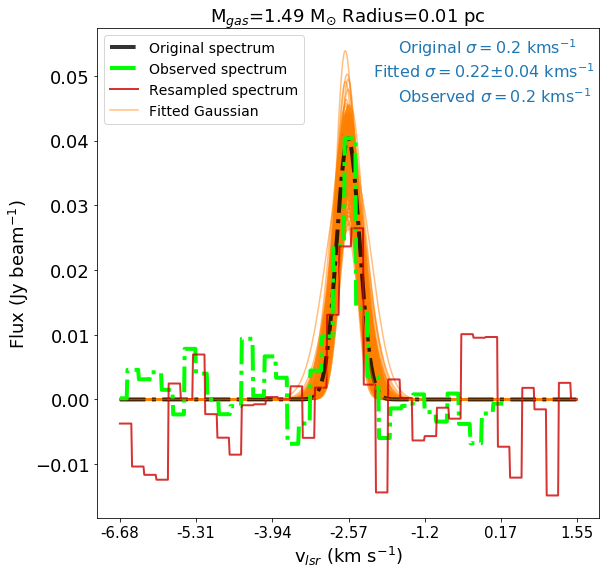

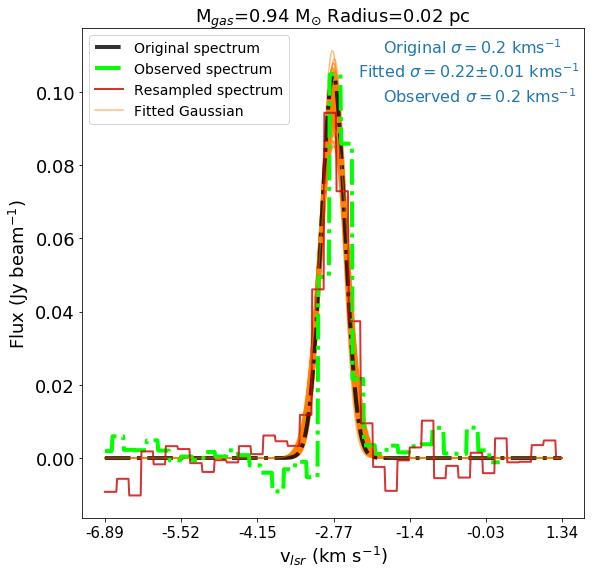

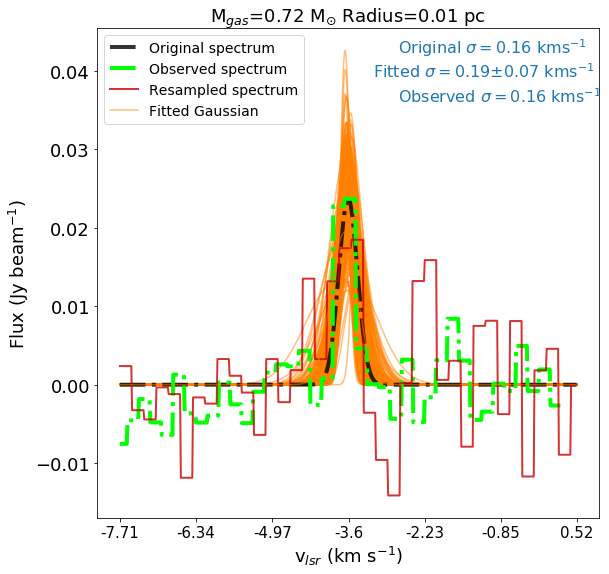

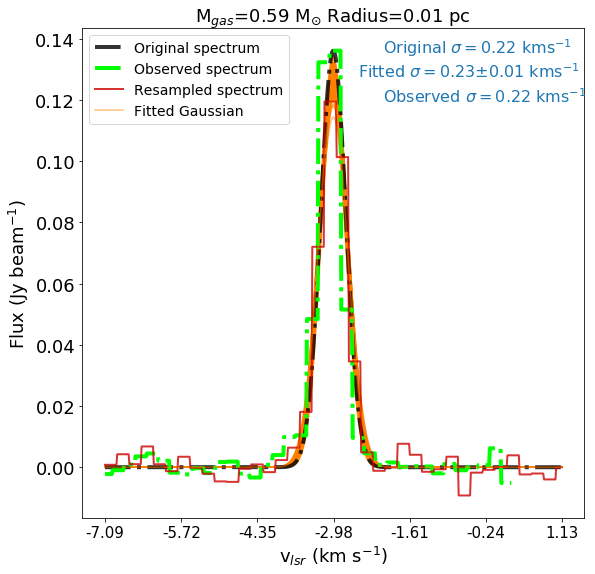

In [11]:
kk = range(0, size(Mgas) )

for i in core_index:
    temp = kk.index(i)
    #print temp
    kk.pop(temp)

#print kk

jj = [29,33,40,45,46,47,48]
for i in jj:
    temp = kk.index(i)
    kk.pop(temp)
#print kk



iterations = 1000
linewidth_fits = np.zeros(iterations)


for i in kk:
#for i in range( 0, 5 ):
  # Initialize figures
    fig = plt.figure(figsize=(9, 9))
    figure = plt.subplot(1, 1, 1)
    figure.tick_params(axis='both', which='major', labelsize=18)


    for itr in range(0, iterations):
        
    # generate spectrum
        test_spectrum = gaussian_spectrum(
                                    name = 'test', 
                                    #A = peak_intensity[i], 
                                    A = np.nanmax(spcube[i]),
                                    sigma = Asig[i]/v_pix, #sigma[i]/v_pix, 
                                    bins = 600)

    # plotting the original gaussian spectrum
        if (itr == (iterations-1) ):
            plt.plot(test_spectrum.x , test_spectrum.data, \
                     '-.',
                     color = (0, 0, 0.0, 0.8),
                     linewidth=4, 
                     label = 'Original spectrum'
                    ) 
            
    # plotting the observed spctrum
            sp_data, fvpix = resampleobs( spcube[i], 600 )
            plt.plot(sp_data, \
                     '-.',
                     color = 'lime',
                     linewidth=4, 
                     label = 'Observed spectrum'
                    ) 

    
        # inject noise
        noise = peak_intensity[i] / peak_sn[i]
        noise = noise * np.sqrt( v_delta / v_pix )
        test_spectrum.add_noise( RMS = noise )
        # plt.plot(
        #        test_spectrum.x , test_spectrum.data,
        #        color = (0, 0.8, 0.0, 0.3),
        #        linewidth=2, label = 'Noisy spectrum'
        #        )
           
        # resampling
        test_spectrum.resample(pixelsize = int(v_delta / v_pix), pixelshift=0)
        if (itr == (iterations-1) ):
            plt.plot(test_spectrum.x , test_spectrum.resampleddata,
               color = (0.8, 0.0, 0.0, 0.8),
               linewidth = 2, 
               label = 'Resampled spectrum'
               )    
        else:
            pass  

        # fit Gaussian and print the results
        coeff = test_spectrum.refit_gaussian()
        spectrum_fit = gauss( test_spectrum.x, *coeff)
        if (itr == (iterations-1) ):    
            plt.plot(test_spectrum.x, spectrum_fit, 
               color = (1, 0.5, 0, 0.5),
               label='Fitted Gaussian'
               )
        else:
            if ( itr % 5 == 0):
                plt.plot(test_spectrum.x, spectrum_fit, 
                color = (1, 0.5, 0, 0.5),
                 )
        linewidth_fits[itr] = coeff[2] * v_delta * (v_pix/v_delta)

        if (itr == 0):
            plt.text( 0.6, 0.95,
               'Original $\sigma=$%s kms$^{-1}$' %(str( round( Asig[i],2 ) )), 
               {'color': 'C0', 'fontsize': 16},
               transform=figure.transAxes
              )
    
        if (itr == (iterations-1) ):
            plt.text( 0.55, 0.9,
                     'Fitted $\sigma=$%s$\pm$%s kms$^{-1}$' 
                    %( str( round( np.mean(linewidth_fits), 2 ) ), str( round( np.std(linewidth_fits), 2 ) )), 
                    {'color': 'C0', 'fontsize': 16},
                    transform=figure.transAxes
                    )

            plt.text( 0.6, 0.85,
                     'Observed $\sigma=$%s kms$^{-1}$' %(str( round( Asig[i], 2 ) )), 
                     {'color': 'C0', 'fontsize': 16},
                     transform=figure.transAxes
                     )
            
    plt.title('M$_{gas}$=%s M$_{\odot}$ Radius=%s pc' 
             %( str( round( Mgas[i],2 ) ), str( round( Reff[i],2 ) )  ), 
             size=18
           )
    plt.xlabel( 'v$_{lsr}$ (km s$^{-1}$)', size=18)
    plt.ylabel( 'Flux (Jy beam$^{-1}$)', size=18)
    plt.xticks((0,100, 200, 300, 400, 500, 600), 
               ('%s'%( str( round(fvpix, 2))),
                '%s'%( str( round(fvpix+100*8.229/600, 2))),
                '%s'%( str( round(fvpix+200*8.229/600, 2))),
                '%s'%( str( round(fvpix+300*8.229/600, 2))),
                '%s'%( str( round(fvpix+400*8.229/600, 2))),
                '%s'%( str( round(fvpix+500*8.229/600, 2))),
                '%s'%( str( round(fvpix+600*8.229/600, 2))),
               ),size=15)
    plt.legend(loc=2, fontsize=14)





In [36]:
print 8.229/(0.21/16.0)
print 

626.971428571


In [100]:
G = 4.301e-3  # pc * Msolar^-1 * (km/s)^2
Reff = 1300./206265 * 1.31961   # pc
M = 0.27323      # Msolar
alpha = 2
sigma2fwhm = 2*np.sqrt(2*np.log(2))

sigma = np.sqrt(alpha * M * G /(5* Reff))
print 'sigma',sigma, 'km/s','\n',\
'FWHM',sigma * sigma2fwhm, 'km/s','\n',\
'Reff',Reff, 'pc'

sigma 0.23773723285703255 km/s 
FWHM 0.5598284013819307 km/s 
Reff 0.00831693695004 pc


In [101]:
G = 4.301e-3  # pc * Msolar^-1 * (km/s)^2
Reff = 1000./206265#1300./206265 * 1.31961   # pc
M = 0.1#0.27323      # Msolar
alpha = 2

sigma = np.sqrt(alpha * M * G /(5* Reff))
print 'sigma',sigma, 'km/s','\n',\
'FWHM',sigma * sigma2fwhm, 'km/s','\n',\
'Reff',Reff, 'pc'

sigma 0.18837683137795902 km/s 
FWHM 0.443593538548233 km/s 
Reff 0.00484813225705 pc
